In [1]:
# Necessery library install
!pip install mysql-connector-python sqlalchemy pandas pymysql

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [3]:
#fetchthetable
from sqlalchemy import create_engine, text
import pandas as pd

user = "root"
pw = "kikodory"
host = "127.0.0.1"
port = 3306
db = "inventorydb"

engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}", pool_pre_ping=True)

# fetch entire table
query = "SELECT * FROM vendor_sales_summary;"
with engine.connect() as conn:
    df_full = pd.read_sql_query(sql=text(query), con=conn)

print("Rows, Columns:", df_full.shape)

Rows, Columns: (10692, 18)


In [47]:
# --- Step 1: Calculate Weighted Profit Margin (business correct way) ---
total_gross_profit = df_full["GrossProfit"].sum()
total_sales = df_full["TotalSalesDollars"].sum()

weighted_profit_margin = (total_gross_profit / total_sales) * 100
print(f"Weighted Profit Margin: {weighted_profit_margin:.2f}%")

# --- Step 2: Calculate Simple Row Average (for comparison with your DAX AVERAGE) ---
df_full["RowMargin"] = df_full["GrossProfit"] / df_full["TotalSalesDollars"]
simple_avg_margin = df_full["RowMargin"].mean() * 100
print(f"Simple Average Profit Margin: {simple_avg_margin:.2f}%")

# --- Step 3: Quick sanity check ---
print("Total Gross Profit:", total_gross_profit)
print("Total Sales Dollars:", total_sales)


Weighted Profit Margin: -874.44%
Simple Average Profit Margin: -inf%
Total Gross Profit: -288866251.53999996
Total Sales Dollars: 33034513.99


In [4]:
from sqlalchemy import text

# Query full table
with engine.connect() as conn:
    vendor_sales_summary = pd.read_sql_query(sql=text("SELECT * FROM vendor_sales_summary;"), con=conn)


In [30]:
vendor_sales_summary

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,2,"IRA GOLDMAN AND WILLIAMS, LLP",90085,Ch Lilian 09 Ladouys St Este,23.86,36.99,750,8,190.88,2,73.98,36.99,0.22,27.08,-116.90,-158.02,0.25,0.39
1,2,"IRA GOLDMAN AND WILLIAMS, LLP",90609,Flavor Essence Variety 5 Pak,17.00,24.99,162,320,5440.00,0,0.00,0.00,0.00,27.08,-5440.00,0.00,0.00,0.00
2,54,AAPER ALCOHOL & CHEMICAL CO,990,Ethyl Alcohol 200 Proof,105.07,134.49,3750,1,105.07,0,0.00,0.00,0.00,0.48,-105.07,0.00,0.00,0.00
3,60,ADAMBA IMPORTS INTL INC,771,Bak's Krupnik Honey Liqueur,11.44,14.99,750,39,446.16,0,0.00,0.00,0.00,367.52,-446.16,0.00,0.00,0.00
4,60,ADAMBA IMPORTS INTL INC,3401,Vesica Vodka,11.10,14.99,1750,6,66.60,0,0.00,0.00,0.00,367.52,-66.60,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,173357,TAMWORTH DISTILLING,2804,Camp Robber Whiskey,32.14,44.99,750,210,6749.40,0,0.00,0.00,0.00,202.50,-6749.40,0.00,0.00,0.00
10688,173357,TAMWORTH DISTILLING,3666,Art in the Age Chicory Root,18.79,24.99,375,520,9770.80,0,0.00,0.00,0.00,202.50,-9770.80,0.00,0.00,0.00
10689,173357,TAMWORTH DISTILLING,3848,Chicory Root Vodka,23.30,30.99,750,28,652.40,0,0.00,0.00,0.00,202.50,-652.40,0.00,0.00,0.00
10690,173357,TAMWORTH DISTILLING,3909,White Mountain Vodka,19.37,24.99,750,1232,23863.84,43,1074.57,799.68,33.88,202.50,-22789.27,-2120.78,0.03,0.05


Exploratory Data Analysis

Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [8]:
#summary statistics
vendor_sales_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,18753.519148,2.00,3951.0000,7153.000,9552.0000,201359.00
Brand,10692.0,18039.228769,12662.187074,58.00,5793.5000,18761.500,25514.2500,90631.00
PurchasePrice,10692.0,24.385303,109.269375,0.36,6.8400,10.455,19.4825,5681.81
ActualPrice,10692.0,35.643671,148.246016,0.49,10.9900,15.990,28.9900,7499.99
Volume,10692.0,847.360456,664.309309,50.00,750.0000,750.000,750.0000,20000.00
TotalPurchaseQuantity,10692.0,3140.886831,11095.086769,1.00,36.0000,262.000,1975.7500,337660.00
TotalPurchaseDollars,10692.0,30106.693372,123067.799627,0.71,453.4575,3655.465,20738.2450,3811251.60
TotalSalesQuantity,10692.0,228.887860,871.127723,0.00,0.0000,12.000,129.2500,28544.00
TotalSalesDollars,10692.0,3089.647773,12181.138259,0.00,0.0000,251.740,2089.5525,444810.74
TotalSalesPrice,10692.0,1508.300788,3902.425486,0.00,0.0000,125.980,1220.6225,64889.97


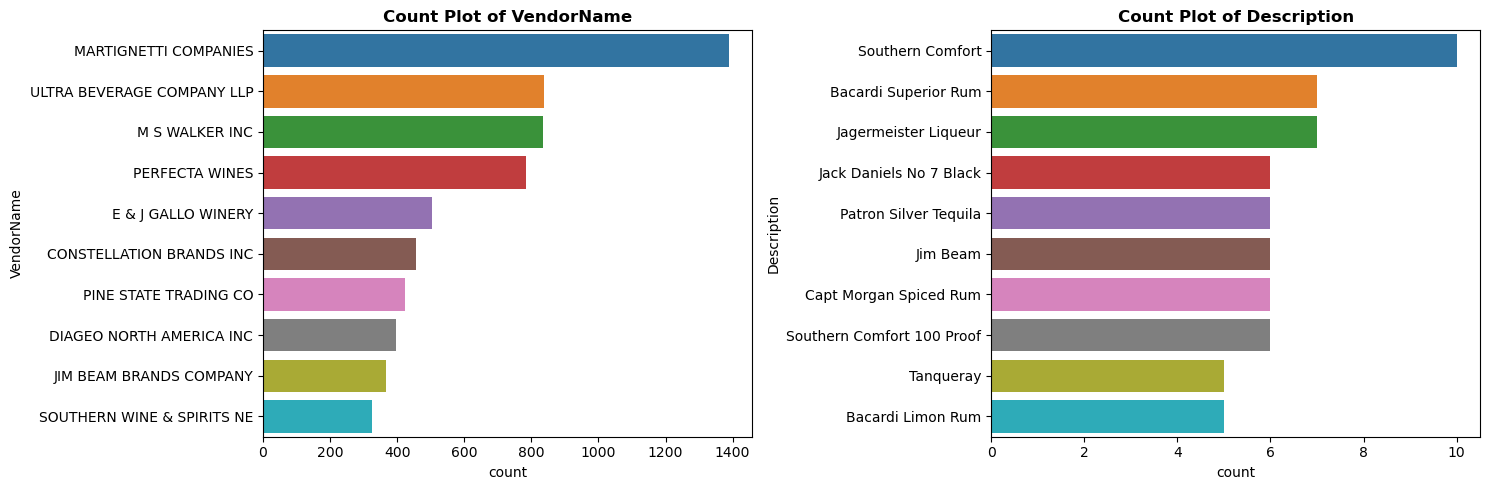

In [32]:
# Select categorical columns
categorical_cols = ["VendorName", "Description"]

# Dynamic subplot grid
n_cols = 2   # number of plots per row
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(categorical_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        y=vendor_sales_summary[col],
        order=vendor_sales_summary[col].value_counts().index[:10]  # Top 10 categories
    )
    plt.title(f"Count Plot of {col}", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()


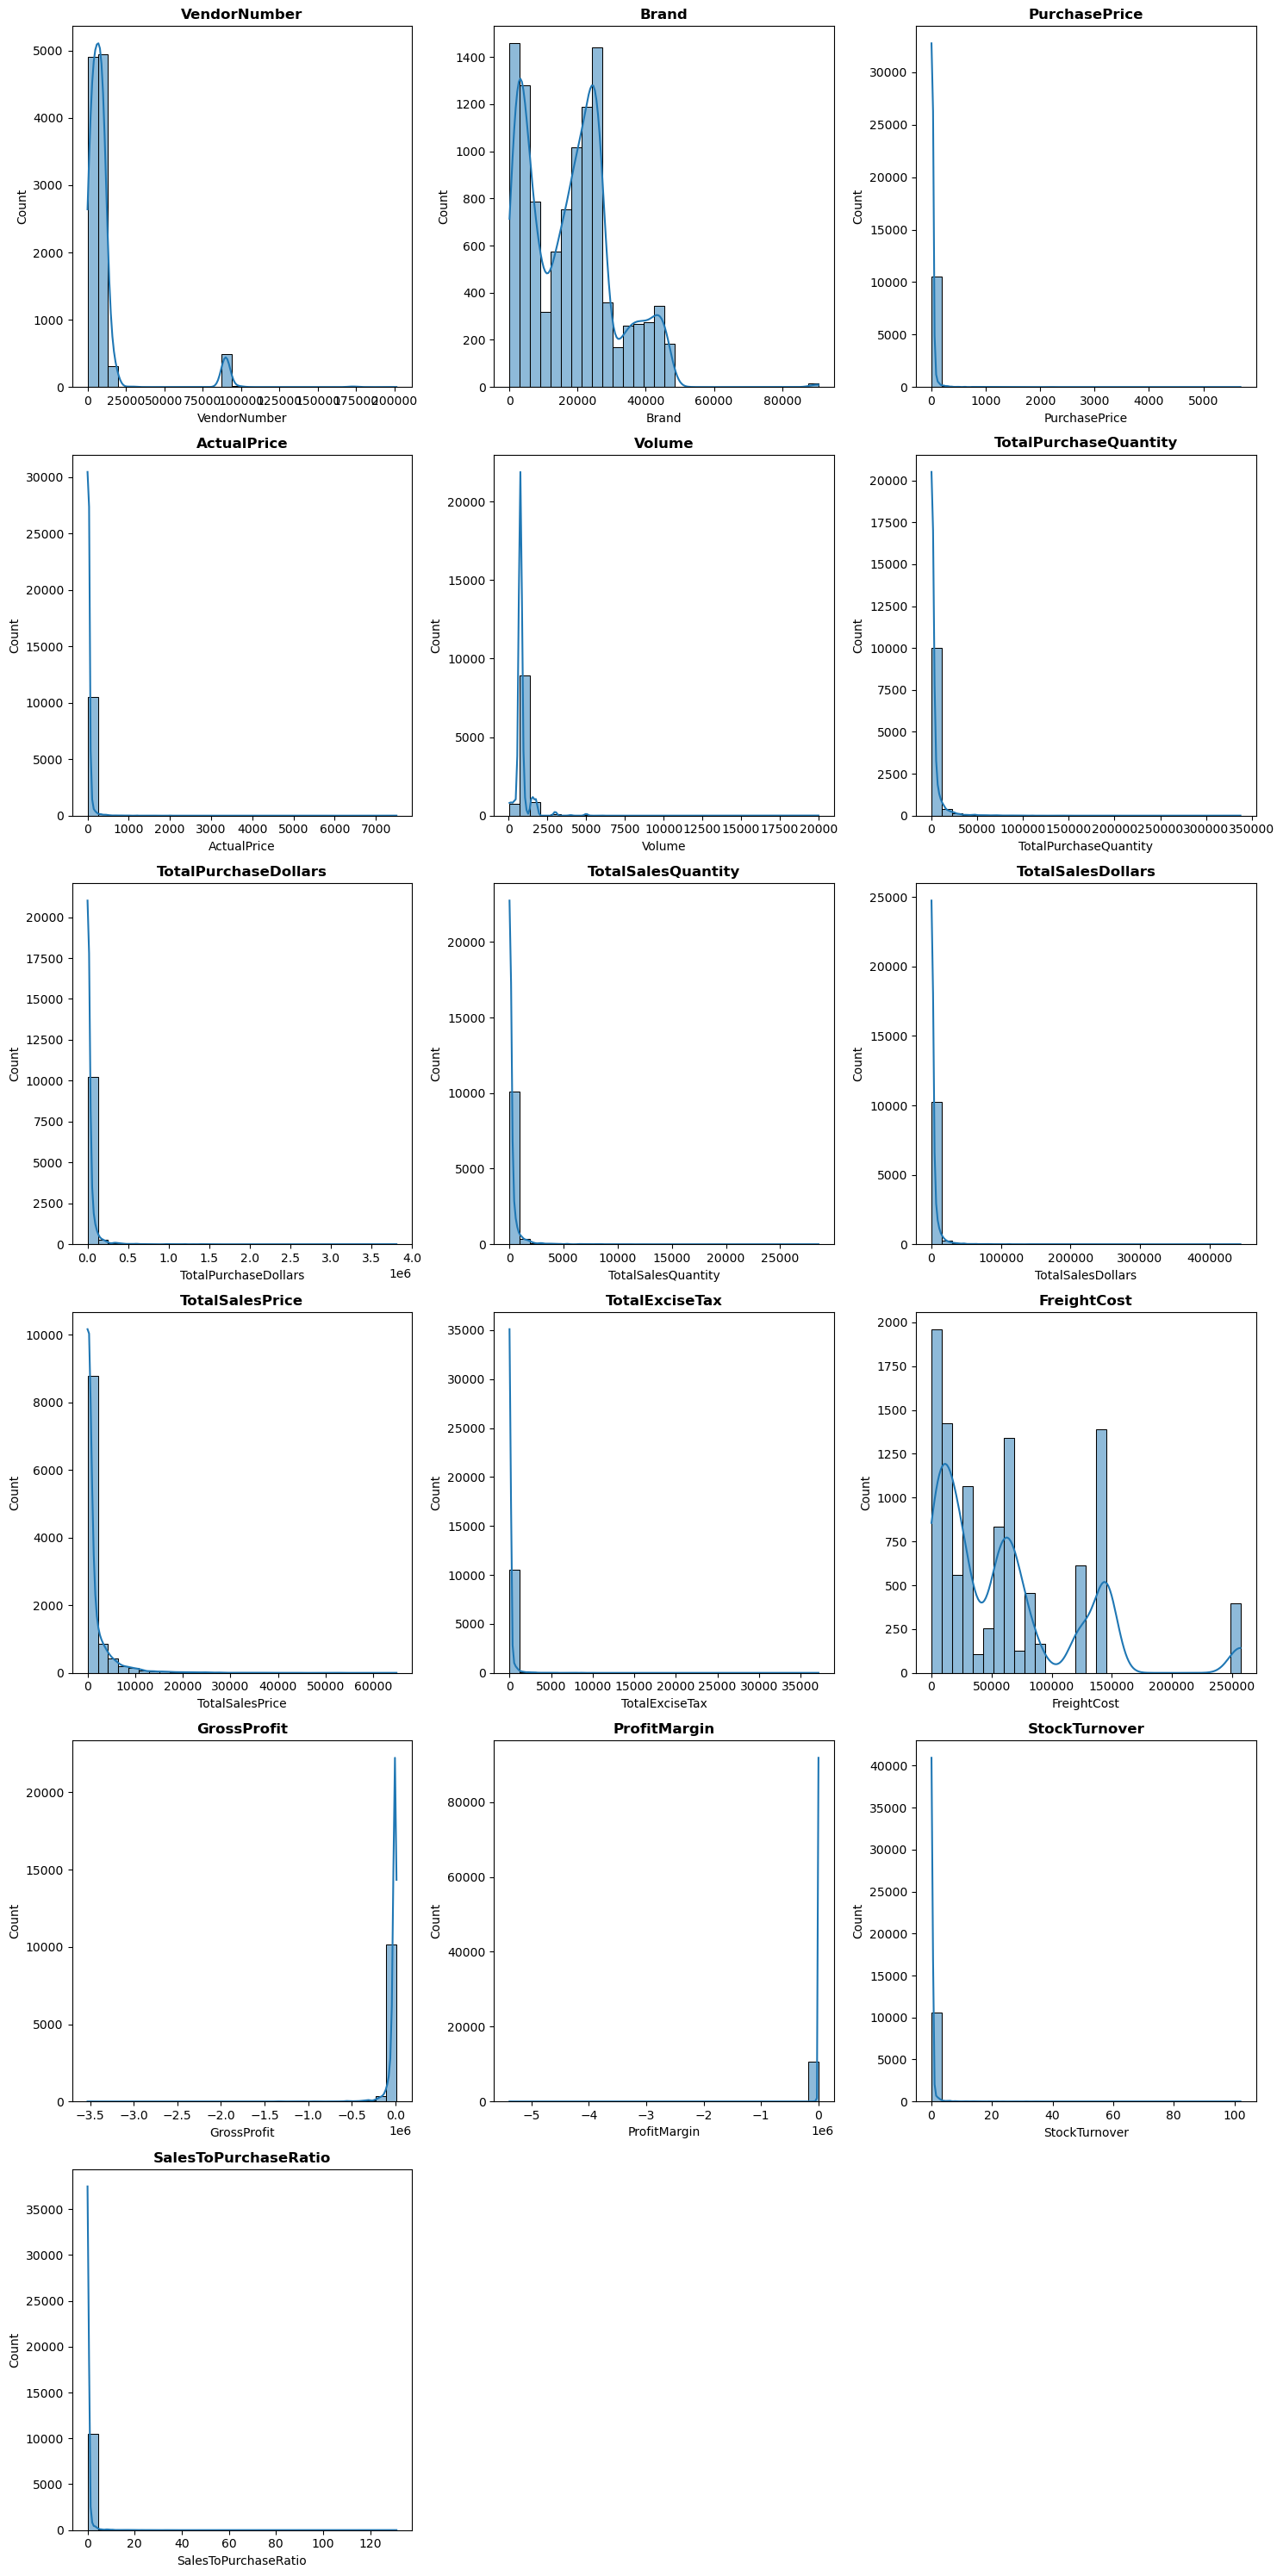

In [10]:
# Select numeric columns
numerical_cols = vendor_sales_summary.select_dtypes(include=np.number).columns

# Dynamic subplot grid
n_cols = 3   # number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(numerical_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(vendor_sales_summary[col], kde=True, bins=30)
    plt.title(col, fontsize=12, weight="bold")

plt.tight_layout()
plt.show()

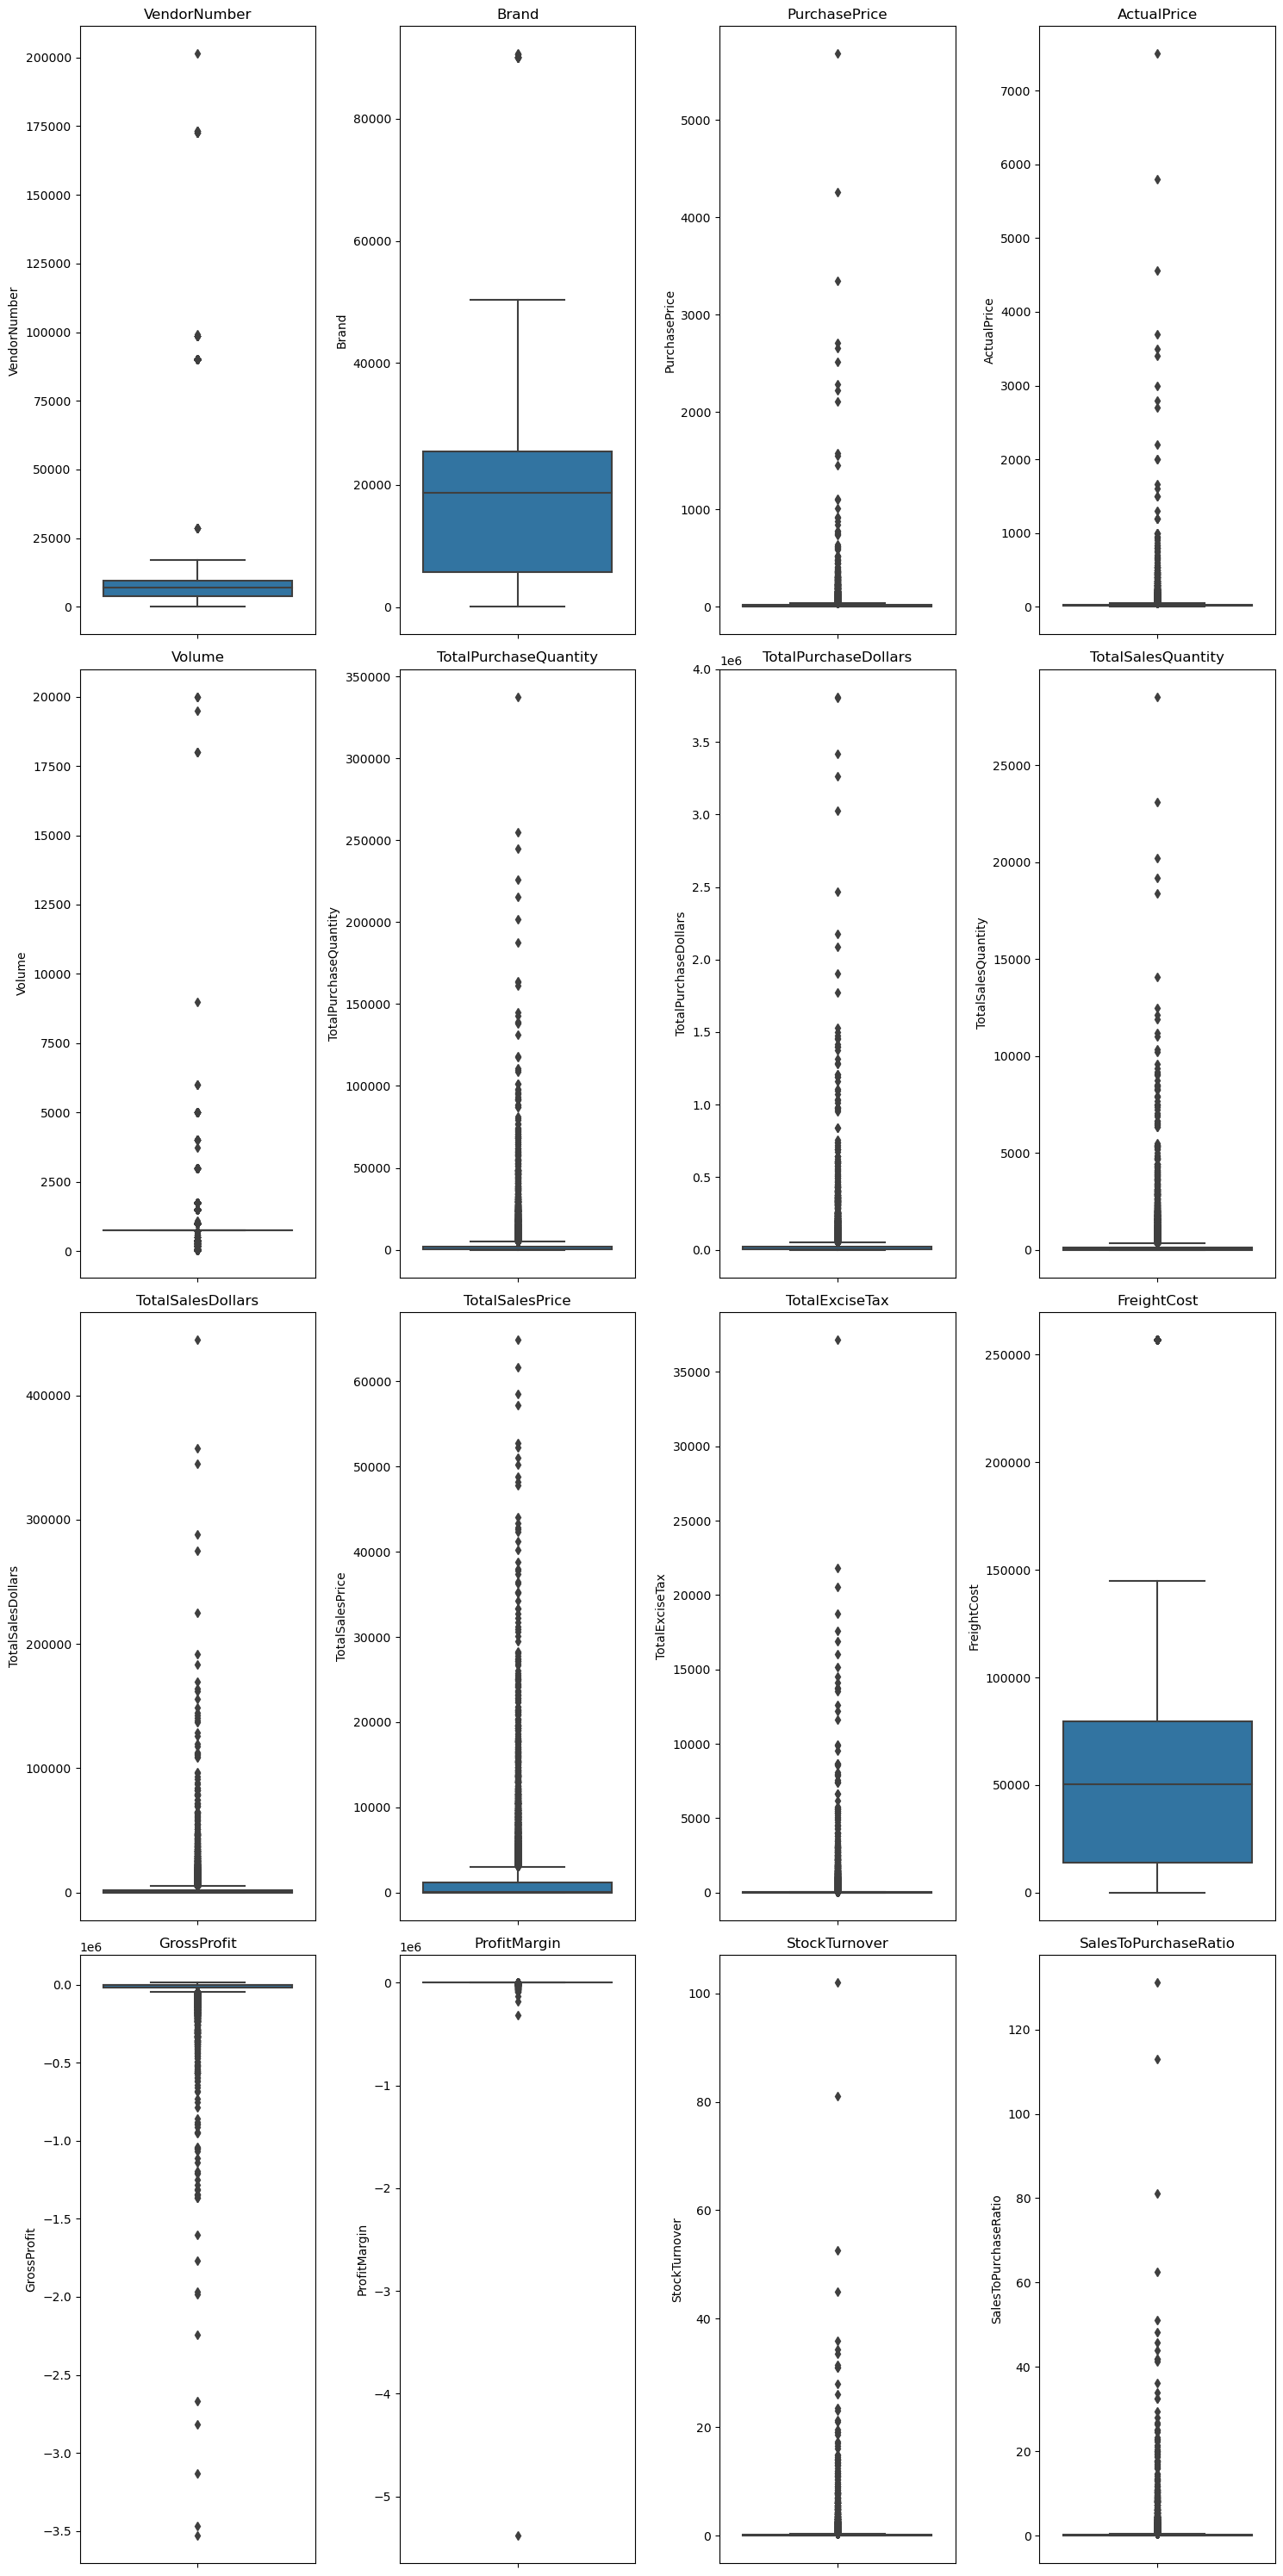

In [12]:
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=vendor_sales_summary[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Summary Statistics Insights
Negative & Zero Values


Gross Profit: The minimum gross profit is around −3,500,000, indicating substantial losses. This suggests some products or transactions may be selling at a loss, either due to discounts, high costs, or pricing errors.

Profit Margin: The minimum margin is extremely negative (close to −5,000,000), suggesting cases where revenues are much lower than costs. This could occur in clearance sales, mispriced items, or data errors.

Sales Quantity & Sales Dollars: Both contain minimum values of 0, meaning some products were purchased but never sold. These may represent obsolete or slow-moving stock.

Outliers Indicated by High Standard Deviations


Purchase & Actual Prices: Maximum values (≈ 5,681 & 7,499) are far higher than their means, indicating the presence of premium or rare products compared to most items.

Volume & Quantities: Both Total Purchase Quantity and Total Sales Quantity show extreme outliers, with very high maximums compared to the median, reflecting bulk transactions.

Total Purchase & Sales Dollars: Extremely high maximums (in the hundreds of thousands to millions) compared to the mean suggest that a small percentage of large transactions drives most of the revenue.

Freight Cost: Ranges widely (up to 250,000+), indicating logistics inefficiencies or bulk/long-distance shipments.

Stock Turnover: Values range from 0 to 100+, implying that some products sell extremely fast while others remain stagnant. Ratios >1 suggest stock was sold from previously purchased inventory.

Sales-to-Purchase Ratio: Mostly small, but extreme outliers (>120) imply potential anomalies where sales far exceed purchases, possibly due to data entry errors, resales, or stock adjustments.

Key Business Insights


Highly skewed data: Most transactions are small-scale, but rare large orders dominate financial totals.

Loss-making products: Negative profits and margins highlight products needing review for pricing, cost efficiency, or promotional strategy.

Logistics inefficiency: Wide freight cost variation may point to opportunities for optimizing supply chain/shipping strategies.

Stock management issues: Zero sales quantities and extreme turnover ratios suggest inefficiencies in inventory planning.


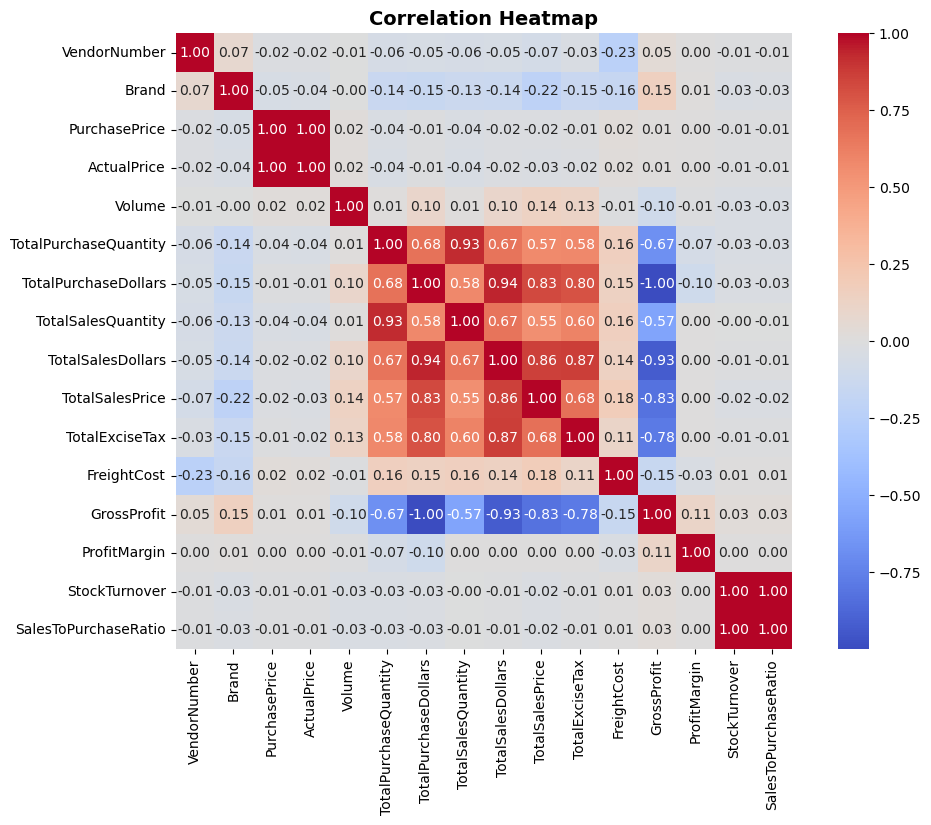

In [34]:
# Correlation Heatmap for all numeric columns
plt.figure(figsize=(12, 8))
corr = vendor_sales_summary.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",   # color palette
    cbar=True,
    square=True
)

plt.title("Correlation Heatmap", fontsize=14, weight="bold")
plt.show()


corelation insight

The dataset shows that purchase and sales metrics are strongly interlinked — more purchases lead to more sales, and higher sales quantities drive higher sales dollars and prices.

Gross Profit stands out with strong negative correlations to purchase and sales values, suggesting that higher sales or purchase volumes do not guarantee higher profitability — costs may be rising faster than revenue.

Taxes and excise duties scale with sales, indicating a direct dependency on sales performance.

Vendor and product attributes (VendorNumber, Brand, PurchasePrice, ActualPrice) have minimal impact on the overall financial correlations, showing that operational scale (quantities, dollars) is a stronger driver than product labels.

Metrics like StockTurnover and SalesToPurchaseRatio show weak correlations, meaning they might not be primary performance drivers but could still offer insights when analyzed in detail.

FOR PROFITABLE PRODUCT

In [28]:
# --- Fetch filtered data (remove inconsistencies) ---
query_filtered = text("""
    SELECT *
    FROM vendor_sales_summary
    WHERE GrossProfit > 0
      AND ProfitMargin > 0
      AND TotalSalesQuantity > 0
""")
with engine.connect() as conn:
    df_filtered = pd.read_sql_query(query_filtered, conn)

print("Filtered Table Shape:", df_filtered.shape)

Filtered Table Shape: (681, 18)


In [29]:
df_filtered

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,388,ATLANTIC IMPORTING COMPANY,7241,Glendalough Poitin Shry Cask,20.68,34.99,750,31,641.08,25,749.75,719.76,2.75,211.74,108.67,14.49,0.81,1.17
1,480,BACARDI USA INC,540,Bacardi Pineapple Fusion,0.72,0.99,50,352,253.44,1080,1069.20,453.42,55.67,89286.27,815.76,76.30,3.07,4.22
2,480,BACARDI USA INC,973,Bacardi 1873 Solera Rum,11.90,19.99,750,21,249.90,22,329.78,239.84,17.34,89286.27,79.88,24.22,1.05,1.32
3,480,BACARDI USA INC,1020,B & B Dom VAP,18.11,28.99,750,2,36.22,47,1174.53,824.67,37.06,89286.27,1138.31,96.92,23.50,32.43
4,480,BACARDI USA INC,1414,Bacardi 8 Gift Set,14.28,23.99,750,5,71.40,27,669.73,244.90,21.27,89286.27,598.33,89.34,5.40,9.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,90047,CRUSH WINES,18394,Ravines Gewurztraminer,10.96,16.99,750,1,10.96,1,16.99,16.99,0.11,1457.73,6.03,35.49,1.00,1.55
677,90047,CRUSH WINES,22168,Tangent Pnt Gris,7.43,10.99,750,79,586.97,62,681.38,274.75,6.92,1457.73,94.41,13.86,0.78,1.16
678,90047,CRUSH WINES,22831,Grady Family Vyds Znfdl,9.08,14.99,750,24,217.92,24,335.76,27.98,2.70,1457.73,117.84,35.10,1.00,1.54
679,90047,CRUSH WINES,23218,Tangent Chard,6.70,9.99,750,663,4442.10,700,6993.00,3086.91,78.00,1457.73,2550.90,36.48,1.06,1.57


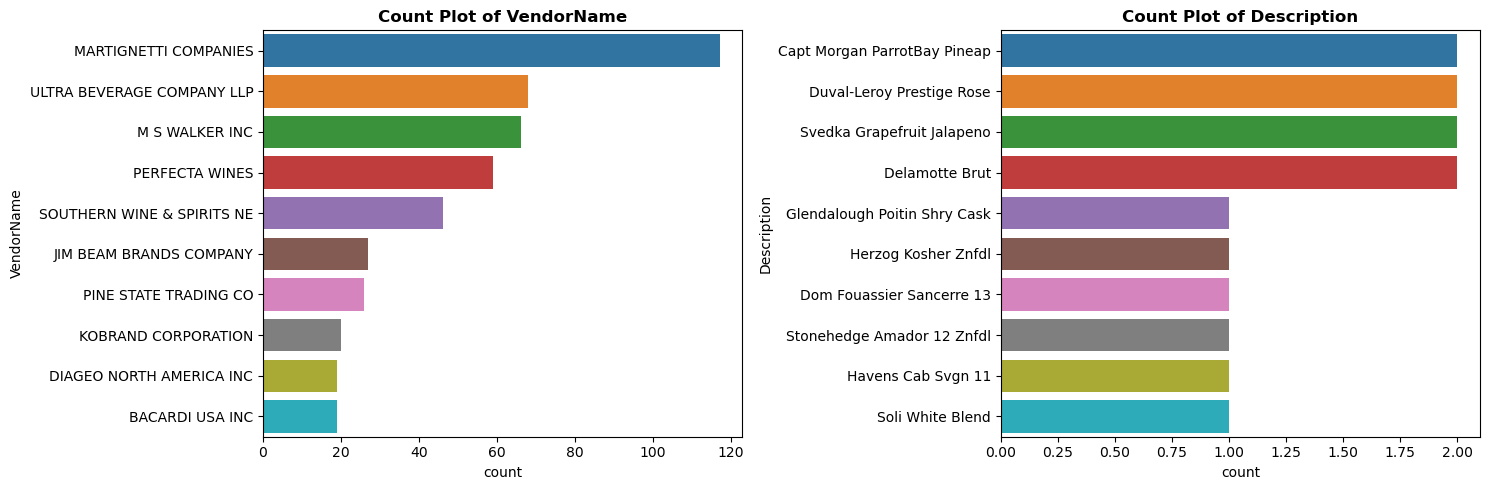

In [33]:
# Select categorical columns
categorical_cols = ["VendorName", "Description"]

# Dynamic subplot grid
n_cols = 2   # number of plots per row
n_rows = int(np.ceil(len(categorical_cols) / n_cols))

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(categorical_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        y=df_filtered[col],
        order=df_filtered[col].value_counts().index[:10]  # Top 10 categories
    )
    plt.title(f"Count Plot of {col}", fontsize=12, weight="bold")

plt.tight_layout()
plt.show()



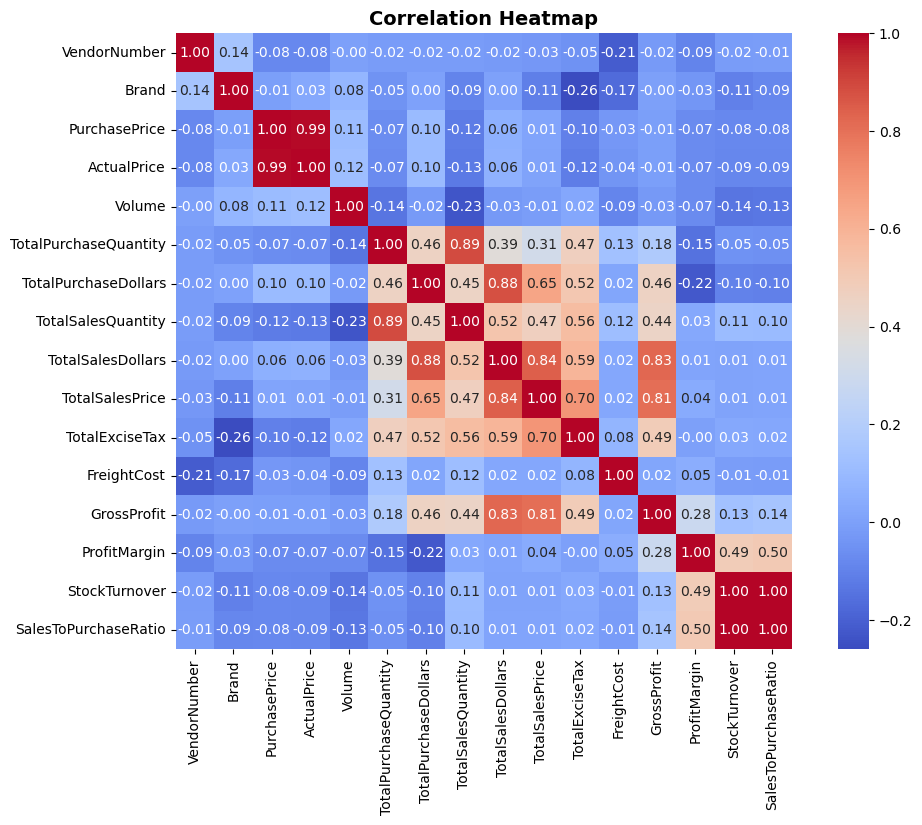

In [35]:
# Correlation Heatmap for all numeric columns
plt.figure(figsize=(12, 8))
corr = df_filtered.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",   # color palette
    cbar=True,
    square=True
)

plt.title("Correlation Heatmap", fontsize=14, weight="bold")
plt.show()


Purchase and sales metrics are strongly connected — higher purchase quantities and dollars drive higher sales quantities and revenue.

Gross Profit is highly correlated with sales values (especially TotalSalesDollars), meaning profit largely depends on sales performance.

Profitability ratios (ProfitMargin, SalesToPurchaseRatio, StockTurnover) show moderate positive correlations, highlighting that efficiency and cost management matter more than just sales volume.

PurchasePrice and ActualPrice move almost identically (0.99), suggesting little variation between buying and selling price.

Vendor and Brand have weak influence on financial outcomes, meaning vendor identity or brand labels don’t significantly affect overall performance.

Taxes and excise duties scale directly with sales, which should be factored into pricing and margin strategies.

In [36]:
# Group by brand/description to calculate total sales and average profit margin
brand_performance = df_filtered.groupby('Description').agg({
    'TotalSalesDollars': 'sum',
    'ProfitMargin': 'mean'
}).reset_index()

# Define thresholds
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

print("Low Sales Threshold:", low_sales_threshold)
print("High Margin Threshold:", high_margin_threshold)

# Filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))


Low Sales Threshold: 119.832
High Margin Threshold: 87.418
Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
616,The Club Strawbry Margarita,11.94,87.69
229,Crown Royal Apple,23.88,88.11
635,Tracia Syrah,44.94,88.50
46,Bacardi Oakheart Spiced Trav,59.94,87.55
256,Dr McGillicuddy's Apple Pie,62.72,96.27
579,St Elder Elderflower Liqueur,66.33,91.44
31,Aresti Pnt Nr Curico Vly,74.85,95.62
239,DeKuyper Buttershots Trav,76.93,90.72
626,Three Olives Grape Vodka,80.19,99.11
580,St Germain Liqueur,89.94,87.66


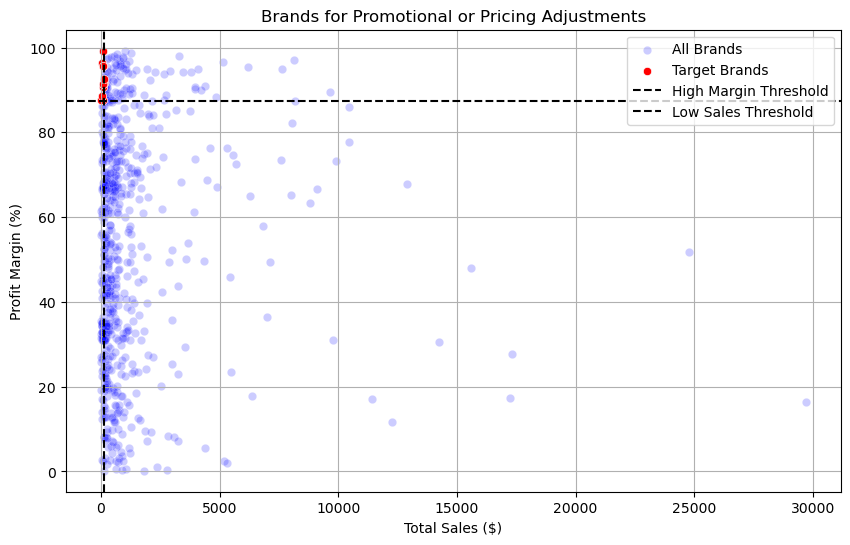

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Scatter plot: All brands
sns.scatterplot(
    data=df_filtered,
    x='TotalSalesDollars',
    y='ProfitMargin',
    color="blue",
    label="All Brands",
    alpha=0.2
)

# Scatter plot: Target brands (low sales + high margin)
sns.scatterplot(
    data=target_brands,
    x='TotalSalesDollars',
    y='ProfitMargin',
    color="red",
    label="Target Brands"
)

# Add threshold lines
plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

# Labels & title
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")

plt.legend()
plt.grid(True)
plt.show()


In [38]:
# 🔹 Top Performing Vendors
top_vendors = df_filtered.groupby('VendorName').agg({
    'TotalSalesDollars': 'sum'
}).reset_index().sort_values(by='TotalSalesDollars', ascending=False)

print("Top Vendors by Total Sales:")
display(top_vendors.head(10))   # Show top 10 vendors


# 🔹 Top Performing Brands
top_brands = df_filtered.groupby('Description').agg({
    'TotalSalesDollars': 'sum'
}).reset_index().sort_values(by='TotalSalesDollars', ascending=False)

print("Top Brands by Total Sales:")
display(top_brands.head(10))   # Show top 10 brands


Top Vendors by Total Sales:


,VendorName,TotalSalesDollars
56,ULTRA BEVERAGE COMPANY LLP,132226.54
30,MARTIGNETTI COMPANIES,125884.74
28,M S WALKER INC,100939.71
37,PERFECTA WINES,62686.86
2,BACARDI USA INC,49095.12
47,SOUTHERN WINE & SPIRITS NE,48248.55
48,STATE WINE & SPIRITS,30773.64
24,JIM BEAM BRANDS COMPANY,28761.34
13,DIAGEO NORTH AMERICA INC,22506.09
4,BROWN-FORMAN CORP,20504.19


Top Brands by Total Sales:


,Description,TotalSalesDollars
165,Ch La Rousseliere St Estephe,29698.02
408,Madison's Ranch Cab Svgn,24797.91
50,Bacardi Twin Pack 2/750mls,17331.33
467,Paul Dolan 12 Cab Svgn,17253.49
244,DiSaronna Amaretto Sour VAP,15596.83
493,Pizzolato Pnt Grigio,14252.61
521,Robert Hall Cab Svgn,12912.77
386,Latour 12 Cuvee Bourg Rouge,12273.86
49,Bacardi Superior Rum,11411.40
536,Saddleback Clrs 09 Cab Svgn,10447.25


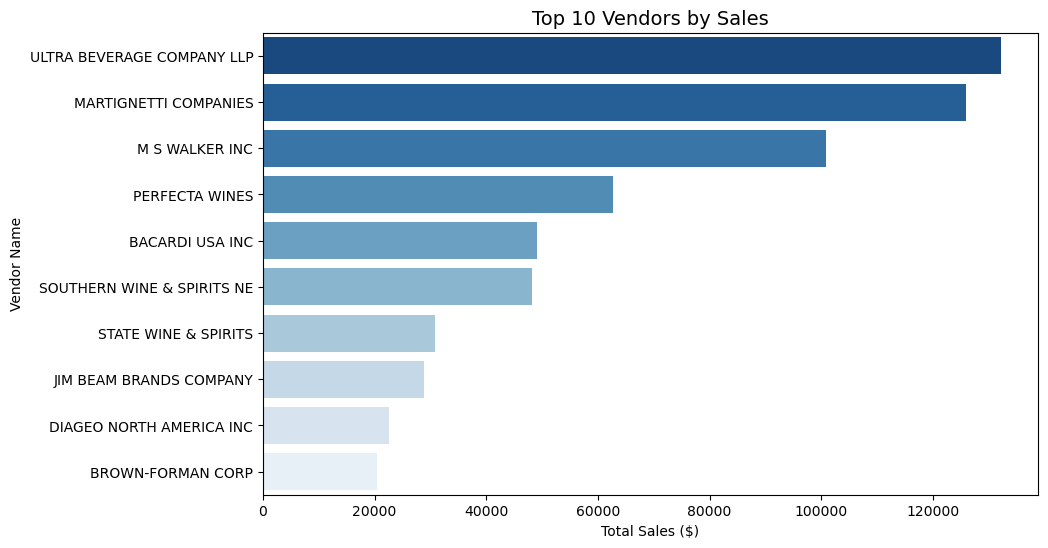

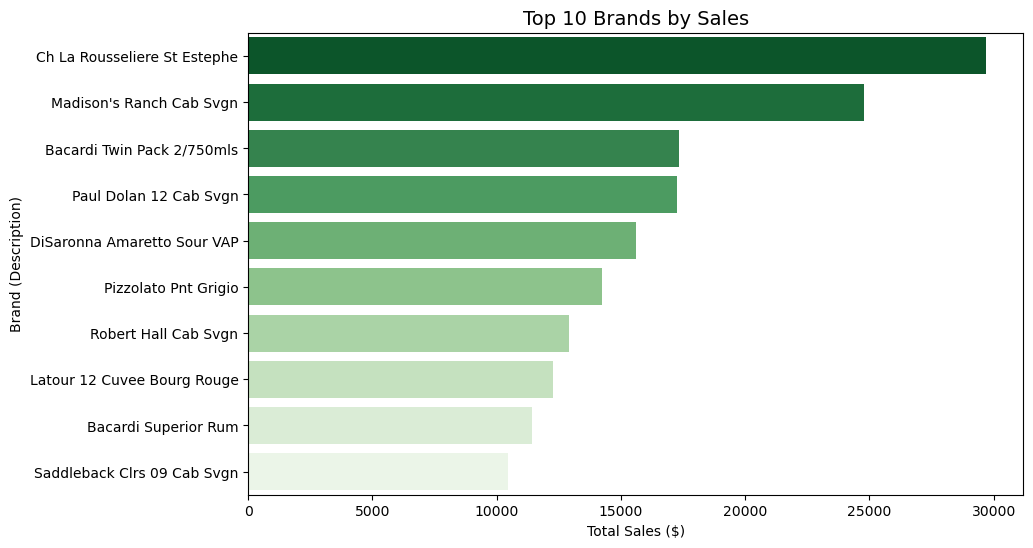

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Top 10 Vendors
top_vendors = df_filtered.groupby('VendorName').agg({
    'TotalSalesDollars': 'sum'
}).reset_index().sort_values(by='TotalSalesDollars', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_vendors, x='TotalSalesDollars', y='VendorName', palette="Blues_r")
plt.title("Top 10 Vendors by Sales", fontsize=14)
plt.xlabel("Total Sales ($)")
plt.ylabel("Vendor Name")
plt.show()


# 🔹 Top 10 Brands
top_brands = df_filtered.groupby('Description').agg({
    'TotalSalesDollars': 'sum'
}).reset_index().sort_values(by='TotalSalesDollars', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_brands, x='TotalSalesDollars', y='Description', palette="Greens_r")
plt.title("Top 10 Brands by Sales", fontsize=14)
plt.xlabel("Total Sales ($)")
plt.ylabel("Brand (Description)")
plt.show()


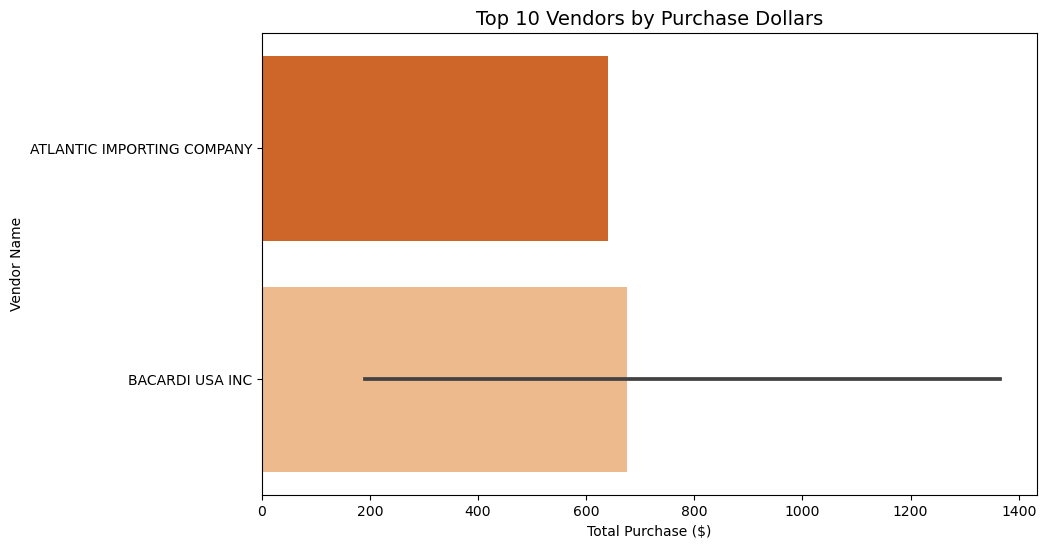

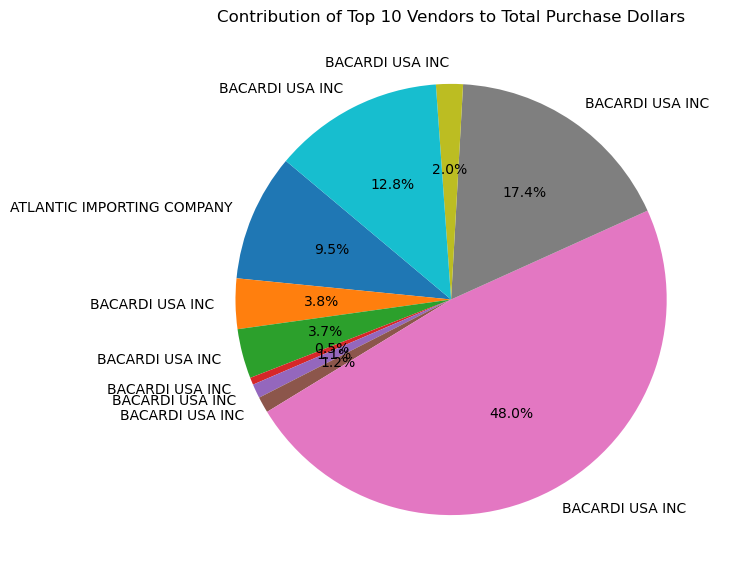

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 vendors by purchase contribution
top_vendor_purchase = df_filtered.head(10)

# 🔹 Bar Plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_vendor_purchase, 
            x='TotalPurchaseDollars', 
            y='VendorName', 
            palette="Oranges_r")
plt.title("Top 10 Vendors by Purchase Dollars", fontsize=14)
plt.xlabel("Total Purchase ($)")
plt.ylabel("Vendor Name")
plt.show()

# 🔹 Pie Chart
plt.figure(figsize=(7,7))
plt.pie(top_vendor_purchase['TotalPurchaseDollars'], 
        labels=top_vendor_purchase['VendorName'], 
        autopct='%1.1f%%', startangle=140)
plt.title("Contribution of Top 10 Vendors to Total Purchase Dollars")
plt.show()


In [42]:
# 🔹 Calculate total purchase by vendor
vendor_purchase = df_filtered.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum'
}).reset_index().sort_values(by='TotalPurchaseDollars', ascending=False)

# Total procurement value
total_procurement = vendor_purchase['TotalPurchaseDollars'].sum()

# 🔹 Dependency on Top N Vendors (e.g., Top 5 and Top 10)
top5_dependency = vendor_purchase.head(5)['TotalPurchaseDollars'].sum() / total_procurement * 100
top10_dependency = vendor_purchase.head(10)['TotalPurchaseDollars'].sum() / total_procurement * 100

print(f"Total Procurement Value: ${total_procurement:,.2f}")
print(f"Dependency on Top 5 Vendors: {top5_dependency:.2f}%")
print(f"Dependency on Top 10 Vendors: {top10_dependency:.2f}%")


Total Procurement Value: $380,398.60
Dependency on Top 5 Vendors: 57.46%
Dependency on Top 10 Vendors: 76.31%


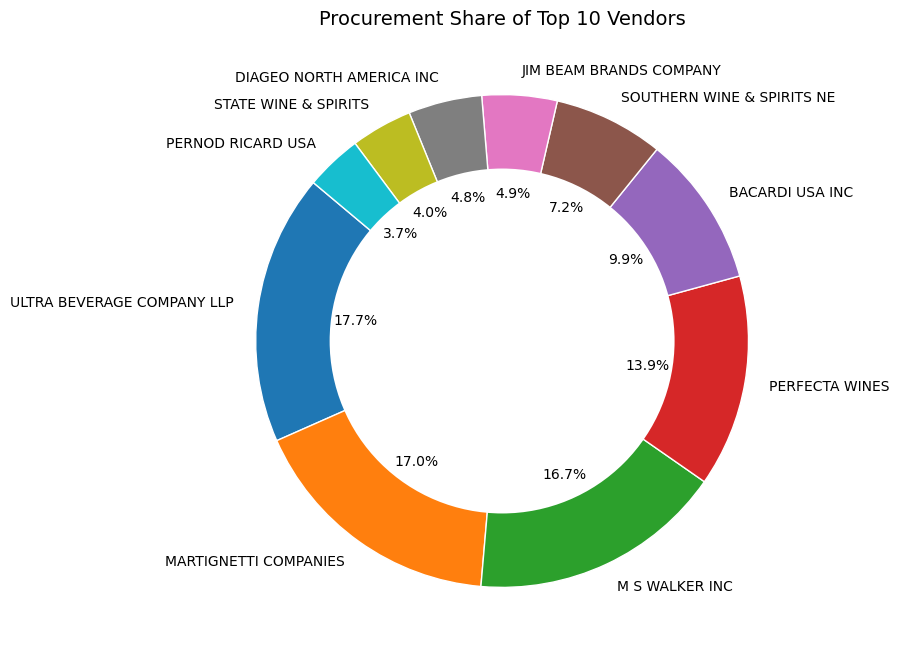

In [43]:
import matplotlib.pyplot as plt

# 🔹 Top 10 vendors by purchase contribution
top_vendors = df_filtered.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum'
}).reset_index().sort_values(by='TotalPurchaseDollars', ascending=False).head(10)

# 🔹 Donut Chart (Top 10 Vendors Only)
plt.figure(figsize=(8,8))
plt.pie(top_vendors['TotalPurchaseDollars'],
        labels=top_vendors['VendorName'],
        autopct='%1.1f%%',
        startangle=140,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Add circle for donut effect
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Procurement Share of Top 10 Vendors", fontsize=14)
plt.show()


OrderSize
Small     36.700159
Medium    22.570569
Large     11.932248
Name: UnitPurchasePrice, dtype: float64


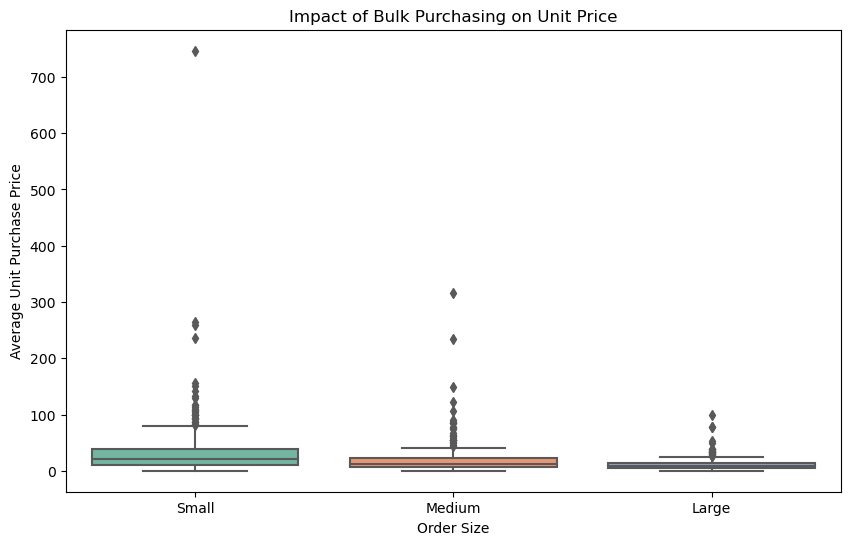

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# Step 1: Calculate Unit Purchase Price
# ------------------------
df_filtered['UnitPurchasePrice'] = df_filtered['TotalPurchaseDollars'] / df_filtered['TotalPurchaseQuantity']

# ------------------------
# Step 2: Categorize Order Size (Small, Medium, Large)
# ------------------------
df_filtered['OrderSize'] = pd.qcut(df_filtered['TotalPurchaseQuantity'], q=3, labels=["Small", "Medium", "Large"])

# ------------------------
# Step 3: Group by Order Size to get Average Unit Price
# ------------------------
avg_price_by_order = df_filtered.groupby('OrderSize')['UnitPurchasePrice'].mean()
print(avg_price_by_order)

# ------------------------
# Step 4: Visualize with Boxplot (use df_filtered)
# ------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='OrderSize', y='UnitPurchasePrice', palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()


Median Price Drops with Larger Orders – The median unit purchase price is highest for Small orders and lowest for Large orders, suggesting bulk purchasing leads to lower per-unit costs.

Price Spread Narrows with Size – The interquartile range (IQR) becomes tighter as order size increases, indicating more price consistency for bulk orders.

Fewer Extreme Outliers in Large Orders – Small orders have many extreme outliers (including very high unit prices), while large orders have fewer, showing more controlled and predictable pricing.

Skewness Reduces with Size – Small orders show strong positive skew (many high-value outliers), whereas large orders are closer to symmetric.

Evidence of Economies of Scale – Overall, the trend shows that buying in bulk reduces both cost variability and average cost per unit.